# Manuscript: Inhibition of NFAT promotes loss of tissue resident uterine natural killer cells and attendant pregnancy complications in humans

## Doublet detection using scrublet (HC10)

In this notebook, we start with a raw counts matrix that was processed with soupX. 
First, let's import the libraries we're going to use and subsequently read in the counts matrix generated by soupX.

### Loading required libraries

In [11]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import matplotlib as mpl
import matplotlib.backends.backend_pdf
import tensorflow as tf
from tensorflow.keras.layers import Add, Input, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Embedding
from tensorflow.keras.layers import Flatten, Concatenate
from tensorflow.keras import regularizers
from keras.regularizers import l1
from keras.regularizers import l2
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.backends.backend_pdf
import warnings
warnings.filterwarnings('ignore')

### Loading soupX filtered data

In [2]:
adata = sc.read_10x_mtx('HC10_soupX_filtered', cache=False)
adata.var_names_make_unique()

Let's take a look at the dataset. The full matrix contains 10491 cells and 33538 genes.

In [3]:
adata

AnnData object with n_obs × n_vars = 10491 × 33538
    var: 'gene_ids'

### Initialize Scrublet object
Refer to: https://github.com/swolock/scrublet/blob/master/examples/scrublet_basics.ipynb

The relevant parameters are:

- expected_doublet_rate: the expected fraction of transcriptomes that are doublets, typically 0.05-0.1. Results are not particularly sensitive to this parameter. For this example, the expected doublet rate comes from the Chromium User Guide: https://support.10xgenomics.com/permalink/3vzDu3zQjY0o2AqkkkI4CC

- sim_doublet_ratio: the number of doublets to simulate, relative to the number of observed transcriptomes. This should be high enough that all doublet states are well-represented by simulated doublets. Setting it too high is computationally expensive. The default value is 2, though values as low as 0.5 give very similar results for the datasets that have been tested.

- n_neighbors: Number of neighbors used to construct the KNN classifier of observed transcriptomes and simulated doublets. The default value of round(0.5*sqrt(n_cells)) generally works well.


For the next step, we would need the expected doublet formation rate. These values can be found here: https://uofuhealth.utah.edu/huntsman/shared-resources/gba/htg/single-cell/genomics-10x

Since our dataset has approximately 10,000 (recovered) cells, we take the corresponding value ~7.6%+ for 10,000 recovered cells given in the table.

In [4]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate = 0.08)

### Run the scrublet pipeline, which includes:

- Doublet simulation
- Normalization, gene filtering, rescaling, PCA
- Doublet score calculation
- Doublet score threshold detection and doublet calling

In [5]:
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets(min_counts=2, min_cells=3, 
                                                          min_gene_variability_pctl=85, n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 4.2%
Estimated detectable doublet fraction = 45.1%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 9.3%
Elapsed time: 13.4 seconds


### Plot doublet score histograms for observed transcriptomes and simulated doublets

The simulated doublet histogram is typically bimodal. The left mode corresponds to "embedded" doublets generated by two cells with similar gene expression. The right mode corresponds to "neotypic" doublets, which are generated by cells with distinct gene expression (e.g., different cell types) and are expected to introduce more artifacts in downstream analyses. Scrublet can only detect neotypic doublets.

To call doublets vs. singlets, we must set a threshold doublet score, ideally at the minimum between the two modes of the simulated doublet histogram. scrub_doublets() attempts to identify this point automatically and has done a good job in this example. However, if automatic threshold detection doesn't work well, you can adjust the threshold with the call_doublets() function. For example:

scrub.call_doublets(threshold=0.25)

The following histogram is an important diagnostic plot. Doublet score threshold should separate the two shoulders of the bimodal distribution. If this is not so, adjust the soublet score cutoff accordingly.

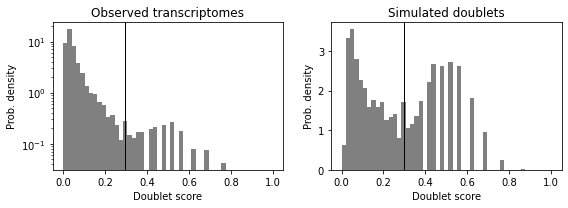

In [6]:
scrub.plot_histogram()

pdf = matplotlib.backends.backend_pdf.PdfPages("HC10_doublet_predictions_histogram.pdf")
for fig in range(1, 2): 
    pdf.savefig( fig )
pdf.close() 

Let's visualize the doublet predictions in a 2-D embedding. Predicted doublets should mostly co-localize (possibly in multiple clusters). If they do not, you may need to adjust the doublet score threshold, or change the pre-processing parameters to better resolve the cell states present in your data. In our case, everything appears to be in order.

In [7]:
adata.obs

,doublet_scores,predicted_doublets
AAACCCAAGAGGATCC-1,0.362720,True
AAACCCACACTGGATT-1,0.054021,False
AAACCCACAGTCTACA-1,0.075205,False
AAACCCAGTAGCACAG-1,0.041154,False
AAACCCAGTGATAGTA-1,0.050147,False
...,...,...
TTTGTTGGTATCTTCT-1,0.054021,False
TTTGTTGGTGCAAGAC-1,0.096070,False
TTTGTTGGTTCGGTAT-1,0.170895,False
TTTGTTGTCCCATTTA-1,0.118063,False


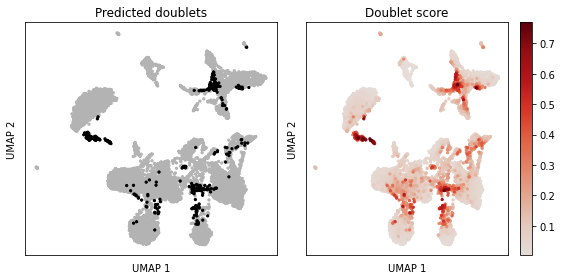

In [8]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True);

pdf = matplotlib.backends.backend_pdf.PdfPages("HC10_doublet_predictions_umap.pdf")
for fig in range(1 ,2):
    pdf.savefig( fig )
pdf.close()

### Save the predictions for further downstream filtering
Finally, let's save a tab-separated file of doublet calls and doublet scores. This data will be used in further downstream analyses and filtering (doublet removal).

In [9]:
adata.obs['predicted_doublets'].value_counts()

False    10049
True       442
Name: predicted_doublets, dtype: int64

In [10]:
pd.DataFrame(adata.obs).to_csv("HC10_scrublet_calls.csv",header = True)